In [2]:
#导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#导入数据
data_origin=pd.read_excel('../data/equipment_loss_rate.xlsx',sheet_name='warship_generate')
data_origin.head()

,time,consume
0,2010/01,246.67281
1,2010/02,253.88689
2,2010/03,248.72287
3,2010/04,262.38641
4,2010/05,243.05669


In [4]:
data_origin.shape

(144, 2)

In [5]:
#画直方图

#画图
plt.figure(figsize=(13,5))
plt.plot(data_origin['time'],data_origin['consume'])
plt.show()

In [ ]:
print(type(data_origin['consume'].values[0])) #看看数据类型是不是float

data_float=data_origin['consume'].values

NameError: name 'data_origin' is not defined

In [ ]:
#将数据集分为训练数据集和验证数据集
test_data_size=12

data_train=data_float[:-test_data_size] #训练集数据132条
data_test=data_float[-test_data_size:]  #验证数据12条

In [ ]:
#数据未经过标准化处理，将数据进行min/max标准化
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(-1,1))
data_train_normalized=scaler.fit_transform(data_train.reshape(-1,1))

ValueError: Expected 2D array, got 1D array instead:
array=[289.96346 288.31422 306.99411 289.68149 282.50668 279.17143 286.60474
 277.1816  283.32489 300.44429 297.95801 304.42627].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
#转化为tensor数据格式
data_train_normalized=torch.FloatTensor(data_train_normalized).view(-1)#转化成1维张量

In [ ]:
#将数据处理成sequences和对应标签形式
#在这里我们取时间窗口为12，因为一年由12个月，这个是比较合理的
train_window=12

def creat_input_sequences(input_data,tw):
    inout_seq=[]
    L=len(input_data)
    for i in range(L-tw):
        train_seq=input_data[i:i+tw]
        train_lable=input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq,train_lable))
    return inout_seq

train_input_seq=creat_input_sequences(data_train_normalized,train_window)
#一共120个样本（132-12=120）

In [ ]:
#创建LSTM模型
class LSTM_timeseq(nn.Module):
    def __init__(self,input_size=1,hidden_layer_size=100,output_size=1):
        super().__init__()

        self.hidden_layer_size=hidden_layer_size
        self.lstm=nn.LSTM(input_size,hidden_layer_size)
        self.linear=nn.Linear(hidden_layer_size,output_size)
        self.hidden_cell=(torch.zeros(1,1,self.hidden_layer_size),torch.zeros(1,1,self.hidden_layer_size))

    def forward(self,input_seq):
        lstm_out,self.hidden_cell=self.lstm(input_seq.view(len(input_seq),1,-1),self.hidden_cell)
        predictions=self.linear(lstm_out.view(len(input_seq),-1))
        return predictions[-1]

input_size：对应的输入数据特征，最然序列长度是12，但是对于每个月来说，我们只有1个值，因此输入的size是1
hidden_layer_size：每层的神经元数量，我们每层有100个神经元
output_size：预测下一个月的输入数量，输出的size为1

LSTM算法接受三个输入：之前的隐藏状态(h)、之前的cell状态(c)以及当前的输入(x)
hiddenn_cell变量包含了先前的隐藏状态和cell状态

lstm的输出包含了当前时间戳下的隐藏状态(h)和cell状态，以及输出(隐藏层状态(h)序列)
lstm层的输出被传递给linear层，进行预测

In [ ]:
#创建模型类的对象、定义损失函数和优化器
model=LSTM_timeseq()
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
#调用GPU

#第一个地方是指定训练设备device
#第二个地方是实例化模型时候把模型加到device
#第三个地方是训练时候把特征和标签加到device, 测试时候也同样需要加到device

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device) #模型放到GPU

#查看模型是否在GPU上：
#print(next(model.parameters()).device)
#查看数据是否在GPU上：
#print(data.device)

True


In [ ]:
# 模型的训练
epochs=50

for i in range(epochs):
    for seq,labels in train_input_seq:
        #特征和标签放到GPU
        #seq.to(device)
        #labels.to(device)

        optimizer.zero_grad()
        model.hidden_cell=(torch.zeros(1,1,model.hidden_layer_size),torch.zeros(1,1,model.hidden_layer_size))

        y_pred=model(seq)

        single_loss=loss_function(y_pred,labels)
        single_loss.backward()
        optimizer.step()
    
    print(f'epoch:{i:3} loss:{single_loss.item():10.8f}')

epoch:  0 loss:0.00118288
epoch:  1 loss:0.00239393
epoch:  2 loss:0.00306075
epoch:  3 loss:0.00305944
epoch:  4 loss:0.01178269
epoch:  5 loss:0.03151003
epoch:  6 loss:0.03147228
epoch:  7 loss:0.02832126
epoch:  8 loss:0.03326660
epoch:  9 loss:0.03566174
epoch: 10 loss:0.03705328
epoch: 11 loss:0.03793054
epoch: 12 loss:0.03845702
epoch: 13 loss:0.03867808
epoch: 14 loss:0.03868313
epoch: 15 loss:0.03855398
epoch: 16 loss:0.03834791
epoch: 17 loss:0.03810439
epoch: 18 loss:0.03785152
epoch: 19 loss:0.03760954
epoch: 20 loss:0.03739338
epoch: 21 loss:0.03721480
epoch: 22 loss:0.03708389
epoch: 23 loss:0.03701068
epoch: 24 loss:0.03700655
epoch: 25 loss:0.03708582
epoch: 26 loss:0.03726792
epoch: 27 loss:0.03757982
epoch: 28 loss:0.03805886
epoch: 29 loss:0.03875565
epoch: 30 loss:0.03973447
epoch: 31 loss:0.04106571
epoch: 32 loss:0.04279999
epoch: 33 loss:0.04491400
epoch: 34 loss:0.04724606
epoch: 35 loss:0.04949744
epoch: 36 loss:0.05135731
epoch: 37 loss:0.05265271
epoch: 38 lo

In [ ]:
#预测
fut_pre=12

test_inputs=data_train_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()#将模型变为预测模式
for i in range(fut_pre):
    seq=torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden=(torch.zeros(1,1,model.hidden_layer_size),torch.zeros(1,1,model.hidden_layer_size))
        test_inputs.append(model(seq).item())

[0.7511299848556519, 0.705441415309906, 0.7083120346069336, 0.5892947912216187, 0.48620736598968506, 0.21069028973579407, 0.20440563559532166, -0.03650671988725662, 0.09908101707696915, 0.008422259241342545, 0.4230861961841583, 0.23953932523727417]


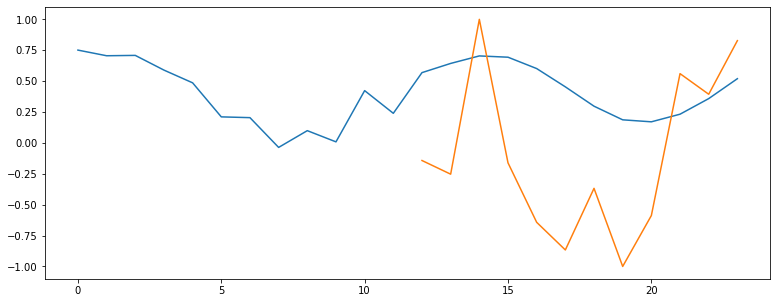

In [ ]:
#预测画图
data_test_normalized=scaler.fit_transform(data_test.reshape(-1,1))

plt.figure(figsize=(13,5))
x=range(len(test_inputs))
plt.plot(x,test_inputs)
plt.plot(x[-len(data_test_normalized):],data_test_normalized)
plt.show()
